# Sentiment Analysis Using Deep Learning

## Word Embeddings

In [1]:
import tensorflow as tf
print("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.0.0


In [2]:
import keras
print("Keras version: " + keras.__version__)

Using TensorFlow backend.


Keras version: 2.3.0


### Processing the labels of the raw movie data

In [3]:
import os

movies_dir = '/Users/jrmth/Desktop/Notebooks/Sentiment Analysis/aclImdb/'
movies_train_dir = os.path.join(movies_dir, 'train')

movie_labels = []
movie_texts = []

for label_type in ['neg', 'pos']:
    movie_dir_name = os.path.join(movies_train_dir, label_type)
    for fname in os.listdir(movie_dir_name):
        if fname[-4:] == '.txt':
            file = os.path.join(movie_dir_name, fname)
            movie_file = open(file, encoding="utf8")
            movie_texts.append(movie_file.read())
            movie_file.close()
            if label_type == 'neg':
                movie_labels.append(0)
            else:
                movie_labels.append(1)

### Tokenizing the text of the raw movie data

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# We'll cut reviews after 200 words
maxlen = 200

# We'll be training on 12500 samples
movie_training_samples = 12500

# We'll be validating on 15000 samples
movie_validation_samples = 15000

# We'll only consider the top 15000 words in the dataset
max_words = 15000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(movie_texts)
sequences = tokenizer.texts_to_sequences(movie_texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

movie_data = pad_sequences(sequences, maxlen=maxlen)

movie_labels = np.asarray(movie_labels)
print('Tensor shape for data:', movie_data.shape)
print('Tensor shape for label:', movie_labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(movie_data.shape[0])
np.random.shuffle(indices)
movie_data = movie_data[indices]
movie_labels = movie_labels[indices]

movie_data_train = movie_data[:movie_training_samples]

movie_labels_train = movie_labels[:movie_training_samples]

movie_data_val = movie_data[movie_training_samples: movie_training_samples + 
                            movie_validation_samples]
movie_labels_val = movie_labels[movie_training_samples: movie_training_samples + 
                                movie_validation_samples]

Found 88582 unique tokens.
Tensor shape for data: (25000, 200)
Tensor shape for label: (25000,)


### Pre-process the embeddings

In [5]:
glove_word_dir = '/Users/jrmth/Desktop/Notebooks/Sentiment Analysis/glove.6B/'

word_embeddings_index = {}
f = open(os.path.join(glove_word_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings_index[word] = coefs
f.close()

print('There are %s word vectors.' % len(word_embeddings_index))

There are 400000 word vectors.


### Preparing the GloVe word-embeddings matrix

In [6]:
word_embedding_dim = 100

word_embedding_matrix = np.zeros((max_words, word_embedding_dim))
for word, i in word_index.items():
    word_embedding_vector = word_embeddings_index.get(word)
    if i < max_words:
        if word_embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            word_embedding_matrix[i] = word_embedding_vector

### Define a model

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

word_embedding_model = Sequential()
word_embedding_model.add(Embedding(max_words, word_embedding_dim, input_length=maxlen))
word_embedding_model.add(Flatten())
word_embedding_model.add(Dense(32, activation='relu'))
word_embedding_model.add(Dense(1, activation='sigmoid'))
word_embedding_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1500000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,140,065
Trainable params: 2,140,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model

In [8]:
word_embedding_model.layers[0].set_weights([word_embedding_matrix])
word_embedding_model.layers[0].trainable = False

### Train and evaluate

In [9]:
word_embedding_model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = word_embedding_model.fit(movie_data_train, movie_labels_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(movie_data_val, movie_labels_val))

word_embedding_model.save_weights('pre_trained_glove_model.h5')

Train on 12500 samples, validate on 12500 samples
Epoch 1/10
12500/12500 [==============================] - 9s 723us/step - loss: 0.7773 - acc: 0.6040 - val_loss: 0.9637 - val_acc: 0.5570
Epoch 2/10
12500/12500 [==============================] - 11s 841us/step - loss: 0.5276 - acc: 0.7399 - val_loss: 0.6407 - val_acc: 0.6739
Epoch 3/10
12500/12500 [==============================] - 11s 843us/step - loss: 0.4245 - acc: 0.8063 - val_loss: 0.6247 - val_acc: 0.7007
Epoch 4/10
12500/12500 [==============================] - 10s 771us/step - loss: 0.3513 - acc: 0.8458 - val_loss: 0.6531 - val_acc: 0.7073
Epoch 5/10
12500/12500 [==============================] - 9s 723us/step - loss: 0.2689 - acc: 0.8867 - val_loss: 0.7154 - val_acc: 0.7010
Epoch 6/10
12500/12500 [==============================] - 10s 812us/step - loss: 0.2156 - acc: 0.9129 - val_loss: 0.8858 - val_acc: 0.6826
Epoch 7/10
12500/12500 [==============================] - 10s 782us/step - loss: 0.1603 - acc: 0.9356 - val_loss: 0.88

### Plotting the results

In [10]:
# this is to render graphs in the notebook
%matplotlib inline 

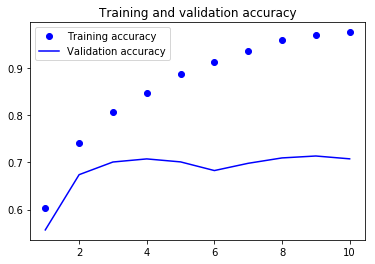

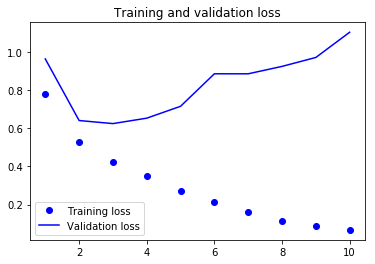

In [11]:
import matplotlib.pyplot as plt

accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Training the same model without pretrained word embeddings

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

no_pretrained_model = Sequential()
no_pretrained_model.add(Embedding(max_words, 
                                  word_embedding_dim, input_length=maxlen))
no_pretrained_model.add(Flatten())
no_pretrained_model.add(Dense(32, activation='relu'))
no_pretrained_model.add(Dense(1, activation='sigmoid'))
no_pretrained_model.summary()

no_pretrained_model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = no_pretrained_model.fit(movie_data_train, movie_labels_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(movie_data_val, movie_labels_val))
no_pretrained_model.save_weights('no_pretrained_model.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          1500000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 2,140,065
Trainable params: 2,140,065
Non-trainable params: 0
_________________________________________________________________


C:\Users\jrmth\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 12500 samples, validate on 12500 samples
Epoch 1/10
12500/12500 [==============================] - 25s 2ms/step - loss: 0.4702 - acc: 0.7573 - val_loss: 0.3215 - val_acc: 0.8627
Epoch 2/10
12500/12500 [==============================] - 29s 2ms/step - loss: 0.1081 - acc: 0.9603 - val_loss: 0.3707 - val_acc: 0.8530
Epoch 3/10
12500/12500 [==============================] - 29s 2ms/step - loss: 0.0073 - acc: 0.9984 - val_loss: 0.5684 - val_acc: 0.8421
Epoch 4/10
12500/12500 [==============================] - 32s 3ms/step - loss: 8.1582e-04 - acc: 0.9998 - val_loss: 0.7268 - val_acc: 0.8362
Epoch 5/10
12500/12500 [==============================] - 28s 2ms/step - loss: 6.4942e-06 - acc: 1.0000 - val_loss: 0.9288 - val_acc: 0.8266
Epoch 6/10
12500/12500 [==============================] - 30s 2ms/step - loss: 8.5122e-08 - acc: 1.0000 - val_loss: 1.0010 - val_acc: 0.8332
Epoch 7/10
12500/12500 [==============================] - 28s 2ms/step - loss: 1.3558e-08 - acc: 1.0000 - val_loss: 

### Plotting the results

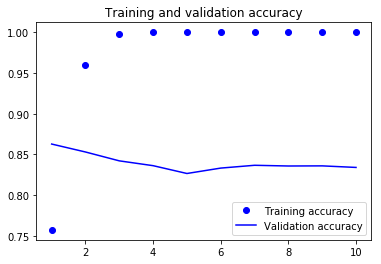

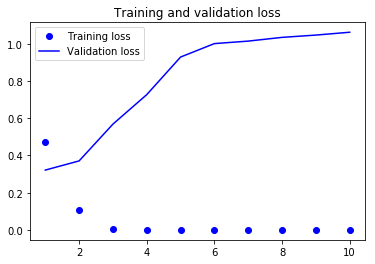

In [13]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Tokenizing the data of the test set

In [14]:
movie_test_dir = os.path.join(movies_dir, 'test')

movie_labels = []
movie_texts = []

for label_type in ['neg', 'pos']:
    movie_dir_name = os.path.join(movie_test_dir, label_type)
    for fname in sorted(os.listdir(movie_dir_name)):
        if fname[-4:] == '.txt':
            movie_file = open(os.path.join(movie_dir_name, fname), encoding="utf8")
            movie_texts.append(movie_file.read())
            movie_file.close()
            if label_type == 'neg':
                movie_labels.append(0)
            else:
                movie_labels.append(1)
                
sequences = tokenizer.texts_to_sequences(movie_texts)
movie_data_test = pad_sequences(sequences, maxlen=maxlen)
movie_labels_test = np.asarray(movie_labels)

### Evaluating the model on the test set

In [15]:
word_embedding_model.load_weights('pre_trained_glove_model.h5')
word_embedding_model.evaluate(movie_data_test, movie_labels_test)

25000/25000 [==============================] - 3s 121us/step


[1.119491793000698, 0.7047200202941895]